## Introduction
The Boston Housing Study dataset has 506 observations and 13 columns. The response variable is the median value of homes in several neighborhoods. Neighborhood category variable was dropped when we prepared data for regression analysis.  We need to use various regression models to determine the overall performance in terms of root-mean-squared error and R-square score, and recommend the best performer to management. <br>

Note: this assignment is a continuation of Assignment 3. As a result, EDA was skipped.

In [1]:
# seed value for random number generators to obtain reproducible results
RANDOM_SEED = 1

# ignore all future warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
import warnings 
warnings.filterwarnings("ignore")

# Execute the code line by line in jupyter-notebook
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# import base packages into the namespace for this program
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# modeling routines from Scikit Learn packages
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, \
cross_val_score, cross_val_predict
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt  # for root mean-squared error calculation


In [2]:
# read data for the Boston Housing Study
boston_input = pd.read_csv('boston.csv')

In [3]:
# drop neighborhood from the data being considered
# response variable is house median value
boston = boston_input.drop('neighborhood', 1)

## Skipping the data exploration and visualization

The data is clean and there are no null values.

## Data Preparation for Modeling

In [4]:
# the mv column is the response variable
# the remaining columns are the explanatory variables

## boston.values # convert to array
y = boston[['mv']].values.ravel()
X = boston.loc[:, 'crim':'lstat'].values

In [5]:
# here we split our data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = RANDOM_SEED)
print("X.shape:", X.shape, "     X_train.shape:", X_train.shape, "     X_test.shape:", X_test.shape)

X.shape: (506, 12)      X_train.shape: (404, 12)      X_test.shape: (102, 12)


## Model Exploration

After splitting the data into training and testing sets, we need to scale explanatory variables for regression modeling. We are scaling the data after slicing it into training and testing sets to prevent data leakage. However, decision tree algorithms (random forest and gradient boosting) don’t depend on scaling; no preprocessing like normalization or standardization of features is needed.

In [6]:
# performance score function with scaling true|false argument
def performance_score (model, model_name, scale = True):
    if scale:
        # scale the data: We added '_R' suffix into sliced data for the purposes of regression modeling. 
        # Variables without this suffix will be used for decision tree modeling.
        scaler = StandardScaler()
        X_train_R = scaler.fit_transform(X_train)
        X_test_R = scaler.fit_transform(X_test)
        # performance score calculation for scaled data
        model = model.fit(X_train_R, y_train)
        train_score = np.round(model.score(X_train_R, y_train),3) # R-square
        test_score = np.round(model.score(X_test_R, y_test),3) # R-square
        train_RMSE = np.round(np.sqrt(mean_squared_error(y_train, model.predict(X_train_R))),3)
        test_RMSE = np.round(np.sqrt(mean_squared_error(y_test, model.predict(X_test_R))),3)
        try:
            print("Number of features used:", np.sum(model.coef_ != 0))
        except:
            pass
    else:
        # performance score calculation for non-scaled data
        model = model.fit(X_train, y_train)
        train_score = np.round(model.score(X_train, y_train),3) # R-square
        test_score = np.round(model.score(X_test, y_test),3) # R-square
        train_RMSE = np.round(np.sqrt(mean_squared_error(y_train, model.predict(X_train))),3)
        test_RMSE = np.round(np.sqrt(mean_squared_error(y_test, model.predict(X_test))),3)
        # r2_score(y_test, forest.predict(X_test))
        try:
            print("Number of features used:", np.sum(model.coef_ != 0))
        except:
            pass
    # performance score table
    col_names = ['Model','Training RMSE', 'Test RMSE', 'Training Score', 'Test Score']
    perf = pd.DataFrame([model_name, train_RMSE, test_RMSE, train_score, test_score], columns = [''],
                            index = col_names).T
    return perf

### Linear Models 
**Linear Regression**

In [7]:
linear = LinearRegression()
linear_p = performance_score(model = linear, model_name = 'Linear Regression', scale = True); linear_p

Number of features used: 12


,Model,Training RMSE,Test RMSE,Training Score,Test Score
,Linear Regression,4.658,4.865,0.73,0.761


We need to lower RMSE and increase R-square score. Linear Regression does not have any regularization parameters.

**Lasso Regression**

Lasso has a regularization parameter, alpha, that controls how strongly coefficients are pushed toward zero. The default alpha is 1.0. We use grid search to get the best alpha.

In [8]:
def optimize (model, param_grid, scale = True):
    if scale:
        # scale the data: We added '_R' suffix into sliced data for the purposes of regression modeling. 
        # Variables without this suffix will be used for decision tree modeling.
        scaler = StandardScaler()
        X_train_R = scaler.fit_transform(X_train)
        X_test_R = scaler.fit_transform(X_test)
        # performance score calculation for scaled data
        gs = GridSearchCV(model, param_grid).fit(X_train_R, y_train)
        print('The optimized alpha value = ', gs.best_params_)
    else:
        # optimization for non-scaled data
        gs = GridSearchCV(model, param_grid).fit(X_train, y_train)
        print('The tuned hyperparamters for Random Forest are:', gs.best_params_)        

In [22]:
# find the best alpha
param_grid = {'alpha': [1e-15, 1e-10, 1e-8, 1e-4, 1e-3, 1e-2, 1, 5, 10, 20]}
optimize(model = Lasso(), param_grid = param_grid, scale = True)

The optimized alpha value =  {'alpha': 0.01}


In [10]:
lasso01 = Lasso(alpha = 0.01)
lasso01_p = performance_score(model = lasso01, model_name = 'lasso01', scale = True); lasso01_p

Number of features used: 12


,Model,Training RMSE,Test RMSE,Training Score,Test Score
,lasso01,4.659,4.868,0.73,0.76


As the value of alpha decreases, the model complexity increases. Though lower values of alpha increase overfitting. The RMSE (error) score is slightly improved. Using alpha = 0.01, we get a model that is quite unregularized, with all coefficients nonzero and of large magnitude. We are using all 12 features. Since alpha is close to zero, coefficients should be the same as simple linear regression. We have around 400 training data. However, with enough training data, regularization becomes less important.

**Ridge Regression**

Ridge also has a regularization parameter, alpha, that controls how strongly coefficients are pushed toward zero. The default alpha is 1.0. We use grid search to get the best alpha.

In [11]:
# find the best alpha
param_grid = {'alpha': [1e-15, 1e-10, 1e-8, 1e-4, 1e-3, 1e-2, 1, 5, 10, 20]}
optimize(model = Ridge(), param_grid = param_grid, scale = True)

The optimized alpha value =  {'alpha': 5}


In [12]:
ridge5 = Ridge(alpha = 5)
ridge5_p = performance_score(model = ridge5, model_name = 'ridge5', scale = True); ridge5_p

Number of features used: 12


,Model,Training RMSE,Test RMSE,Training Score,Test Score
,ridge5,4.662,4.871,0.73,0.76


The RMSE score is slightly higher than lasso and linear regression. <br>
<br>
Utilizing default 3-fold cross-validation, each of these models returned an RMSE test score between 4.865 and 4.871 as well as a test R-value score of 0.76.  While all of the regression models are competitive, linear regression has an advantage with a slightly lower residual error, and should the analysis within this assignment end here; linear regression would be the selected champion model.


### Decision Trees: 
**Random Forrest**

Ensembles are methods that combine multiple decision tree models to create more powerful models: random forests and gradient boosted decision trees. <br>
As each feature is processed separately, and the possible splits of the data don’t depend on scaling, no preprocessing like normalization or standardization of features is needed for decision tree algorithms. In particular, decision trees work well when we have features that are on completely different scales, or a mix of binary and continuous features.

In [13]:
# identify the features that are most important in predicting home prices
def plot_feature_importances(model):
    feature_importance = \
    pd.DataFrame(model.feature_importances_, index = boston.columns.drop('mv'), 
                 columns=['importance']).sort_values('importance', ascending = True)
    feature_importance.plot.barh();

Baseline random forest model

,Model,Training RMSE,Test RMSE,Training Score,Test Score
,Random Forest,1.281,3.199,0.98,0.896


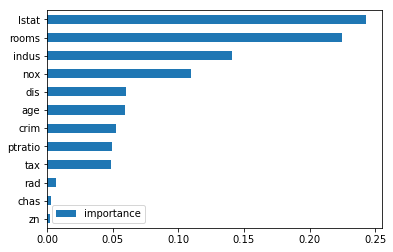

In [14]:
forest = RandomForestRegressor(random_state = RANDOM_SEED, max_features = 'log2')
forest_p = performance_score(model = forest, model_name = 'Random Forest', scale = False); forest_p
plot_feature_importances(forest)

Default values: 
* We repeatedly draw a sample randomly with replacement (meaning the same sample can be picked multiple times) or bootstrap = True 
* The number of trees in the forest or n_estimators = 10

The random forest without tuning parameters gives us a lower RMSE of 3.199 and higher R-square score of 90%, better than the linear models.
<br><br>
Since Boston dataset has 506 observations with 12 explanatory features, trees can grow large and deep. We need to optimize or tune hyperparameters of our model. The evaluation includes a default 3 -fold cross validation.

In [15]:
# find the best parameters
param_grid = {
            'n_estimators': [5, 10, 50, 100, 200, 300, 400, 500, 600],
            'max_depth': [3, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
            'bootstrap': [True]
}

optimize(model = RandomForestRegressor(random_state = RANDOM_SEED, max_features = 'log2'), 
         param_grid = param_grid, scale = False)

The tuned hyperparamters for Random Forest are: {'bootstrap': True, 'max_depth': 30, 'n_estimators': 200}


,Model,Training RMSE,Test RMSE,Training Score,Test Score
,Random Forest Optimized,1.151,3.179,0.984,0.898


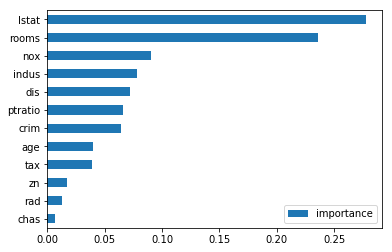

In [16]:
#forest_optimized  = gs.best_estimator_
forest_optimized  =  RandomForestRegressor(random_state = RANDOM_SEED, max_features = 'log2',
                                           bootstrap = True, 
                                           max_depth= 30, 
                                           n_estimators = 200)
forest_optimized_p = performance_score(model = forest_optimized, model_name = 'Random Forest Optimized', 
                                       scale = False); forest_optimized_p
plot_feature_importances(forest_optimized)

The optimized random forest is better than the regression models we tested earlier. The random forest models provided us a lower RMSE and a higher R- square scores. However, we need to evaluate gradient boosting before we make our conclusion.

When I increased the number of trees from the default ten trees to 200 trees, assigning maximum depth value gave slightly better results. 
<br><br>
According to the random forest features importance model, the poverty rate (lstat), rooms per house (rooms), air pollution (nox), industrial area (indus), and commute to work (dis) features are important to predict the median value of homes.

**Gradient Boosting** <br>
Each tree tries to correct the mistakes of the previous one. By default, there is no randomization in gradient boosted regression trees; instead, strong pre-pruning is used.

Baseline gradient boosting model

,Model,Training RMSE,Test RMSE,Training Score,Test Score
,Gradient Boosting,1.486,3.066,0.973,0.905


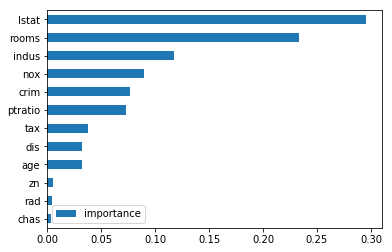

In [17]:
GB = GradientBoostingRegressor(random_state = RANDOM_SEED, max_features = 'log2')
GB_p = performance_score(model = GB, model_name = 'Gradient Boosting', scale = False); GB_p
plot_feature_importances(GB)

Gradient boosting gave us much better results than the regression and random forest models which we tested earlier.  <br><br>
We can see that the feature importances of the gradient boosted trees are somewhat similar to the feature importances of the random forests, though the gradient boosting completely ignored some of the features. According to the  Gradient Boosting features importance model, the poverty rate (lstat), rooms per house (rooms), industrial area (indus), air pollution (nox), and crime rate (crim) features are important to predict the median value of homes.

In [18]:
# find the best parameters
param_grid = {
    'learning_rate': [0.1, 0.05, 0.02, 0.01, 0.005, 0.001],
    'max_depth': [2, 4, 6],
    'n_estimators': [100, 200, 500, 600]
}
optimize(model = GradientBoostingRegressor(random_state = RANDOM_SEED, max_features = 'log2'), 
         param_grid = param_grid, scale = False)

The tuned hyperparamters for Random Forest are: {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 600}


,Model,Training RMSE,Test RMSE,Training Score,Test Score
,GB Optimized,0.481,2.944,0.997,0.912


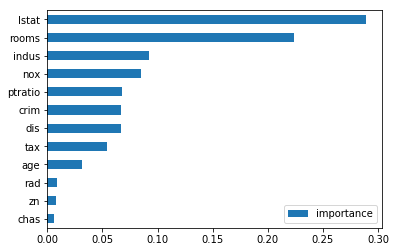

In [19]:
GB_optimized  =  GradientBoostingRegressor(random_state = RANDOM_SEED, max_features = 'log2',
                                       learning_rate = 0.01, 
                                       max_depth = 6, 
                                       n_estimators = 600)
GB_optimized_p = performance_score(model = GB_optimized, model_name = 'GB Optimized', 
                                   scale = False); GB_optimized_p
plot_feature_importances(GB_optimized)

In addition, tuning the learning rate and max depth parameters made further improvements.The optimized gradient boosting model outperformed the rest of the models. It is our winner model.The optimized gradient boosting model provided us the lowest test RMSE and the highest R-square scores. <br> The relative importance of the features within each model is somewhat similar. Both models are aligned in identifying the top five features which may satisfy management's inquiry.

**Summary**

In [20]:
pd.concat([linear_p, lasso01_p, ridge5_p, forest_p, forest_optimized_p,
           GB_p, GB_optimized_p], axis = 0)

,Model,Training RMSE,Test RMSE,Training Score,Test Score
,Linear Regression,4.658,4.865,0.73,0.761
,lasso01,4.659,4.868,0.73,0.76
,ridge5,4.662,4.871,0.73,0.76
,Random Forest,1.281,3.199,0.98,0.896
,Random Forest Optimized,1.151,3.179,0.984,0.898
,Gradient Boosting,1.486,3.066,0.973,0.905
,GB Optimized,0.481,2.944,0.997,0.912


I recommend an optimized Gradient Boosting model to the real estate brokerage firm to assess residential real estate market values. Both Random Forest and Gradient Boosting outperformed every regression model. The Gradient Boosting with tuned parameters demonstrated the strongest fit. One apparent disadvantage of using Gradient Boosting is the lack of transparency in the model's algorithm. If the expectation is to describe how the model derives its findings, then this may pose a challenge to articulate the algorithm.
In regards to features that are predictive to home values, the predominant features are the poverty rate (lstat), rooms per house (rooms), industrial area (indus), air pollution (nox), pupil/teacher ratio (ptratio), and crime rate (crim). Each of these features, while differing in relative importance within the competing Gradient Boosting models, demonstrated significantly higher importance scores over all other features.